<a href="https://colab.research.google.com/github/SanjayGanapathy/HousePricePrediction/blob/main/Benchmark_Dataset_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Unsupervised Anomaly Detection with a Benchmark Dataset**


* This Colab Notebook is meant to explore anomalous data and variable relations in benchmark Data with Temperature Data.
* The prupose of this code is to try to create a solidly working model that can be applied to different kinds of data.  
* The primary method of detection is using Machine Learning Anomaly Detection models.


# Required Packages

Algorithms implemented below:

* Isolation Forest
* One class SVM
* RNN [Recurrent Neural Network for deep Learning]
* Markov Chain

In [ ]:
!git clone https://github.com/numenta/NAB.git

fatal: destination path 'NAB' already exists and is not an empty directory.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.dates as md
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
import json
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
import random

# Loading & Assessing Dataset

Dataset sourced from Kaggle and serves as a benchmark for model performance. The data is made of 58 labeled real-world and artificial timeseries data files plus a new scoring mechanism designed for real-time applications. All of the data is purely open source. Please refer to the link for more information about the dataset and/or data. For now, we are looking at anomalies in terms of temperature data over time.

Link: https://www.kaggle.com/datasets/boltzmannbrain/nab

---



In [ ]:
# Load the dataset
df = pd.read_csv("/content/NAB/data/realKnownCause/ambient_temperature_system_failure.csv")

# Convert timestamp to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Sort the dataframe by timestamp
df = df.sort_values('timestamp').reset_index(drop=True)


In [ ]:
df.describe()

,timestamp,value
count,7267,7267.000000
mean,2013-12-17 01:43:01.477914112,71.242433
min,2013-07-04 00:00:00,57.458406
25%,2013-10-01 13:30:00,68.369411
50%,2013-12-19 04:00:00,71.858493
75%,2014-03-06 01:30:00,74.430958
max,2014-05-28 15:00:00,86.223213
std,NaN,4.247509


# **Standardized Anomaly Injection**

In [ ]:
random_numbers = [random.randint(1, 7267) for _ in range(365)]
generated_anomalies = [random.randint(100, 200) for _ in range (365)]
def inject_anomalies(df):
    df_copy = df.copy()
    for i, index in enumerate(random_numbers):
        df_copy.at[index, 'value'] += generated_anomalies[i]
    return df_copy

# **Standardized Evaluation using the Benchmark Dataset**

In [ ]:
def evaluate_model(true_labels, predicted_labels):
    print("Classification Report:")
    print(classification_report(true_labels, predicted_labels))
    print("Confusion Matrix:")
    print(confusion_matrix(true_labels, predicted_labels))

# **Standardized Visualization**

In [ ]:
def plot_confusion_matrix(true_labels, predicted_labels):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# One Class SVM

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.70      0.82      6907
         1.0       0.11      0.72      0.19       360

    accuracy                           0.70      7267
   macro avg       0.55      0.71      0.51      7267
weighted avg       0.94      0.70      0.79      7267

Confusion Matrix:
[[4850 2057]
 [  99  261]]


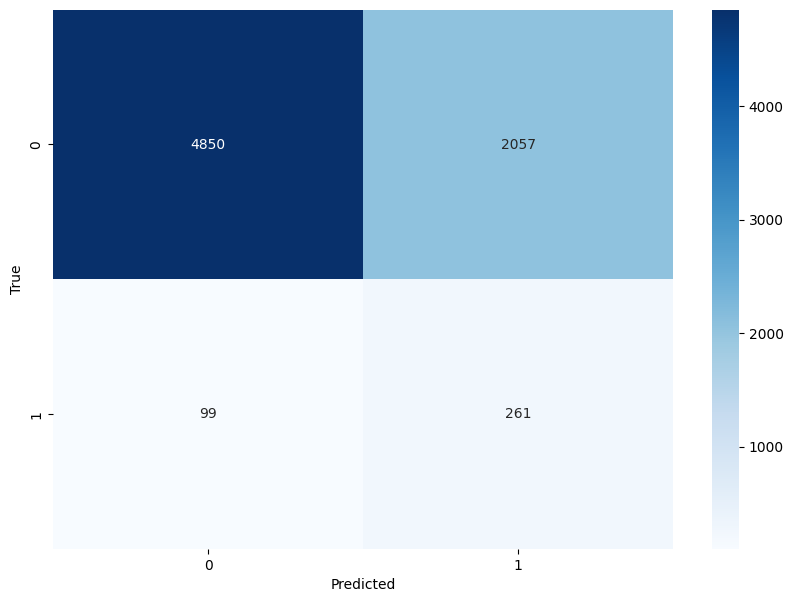

In [ ]:
df_with_anomalies = inject_anomalies(df)

X = df_with_anomalies['value'].values.reshape(-1, 1)

# Fit the OCSVM model
ocsvm = OneClassSVM(nu=0.05, gamma='auto')
ocsvm.fit(X)

# Predict anomalies
predicted_labels = ocsvm.predict(X)
predicted_labels = np.where(predicted_labels == 1, 0, 1)  # Convert to binary labels
true_labels = np.zeros(len(df))
true_labels[random_numbers] = 1

# Evaluate the model
evaluate_model(true_labels, predicted_labels)

# Visualize the confusion matrix
plot_confusion_matrix(true_labels, predicted_labels)



# **Isolation Forest**

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6907
         1.0       0.93      0.94      0.93       360

    accuracy                           0.99      7267
   macro avg       0.96      0.97      0.96      7267
weighted avg       0.99      0.99      0.99      7267

Confusion Matrix:
[[6880   27]
 [  23  337]]


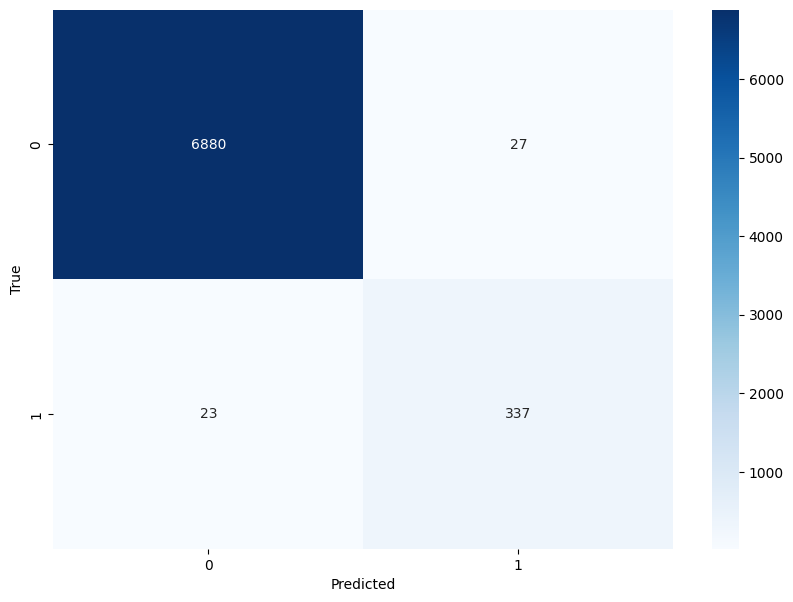

In [ ]:
# Fit the Isolation Forest model
isolation_forest = IsolationForest(contamination=0.05)
isolation_forest.fit(X)

# Predict anomalies
predicted_labels = isolation_forest.predict(X)
predicted_labels = np.where(predicted_labels == 1, 0, 1)  # Convert to binary labels

# Evaluate the model
evaluate_model(true_labels, predicted_labels)

# Visualize the confusion matrix
plot_confusion_matrix(true_labels, predicted_labels)


# **Markov Chains**

In [ ]:
!pip install hmmlearn
from hmmlearn import hmm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 3.3 MB/s eta 0:00:00


Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6907
         1.0       1.00      1.00      1.00       360

    accuracy                           1.00      7267
   macro avg       1.00      1.00      1.00      7267
weighted avg       1.00      1.00      1.00      7267

Confusion Matrix:
[[6907    0]
 [   0  360]]


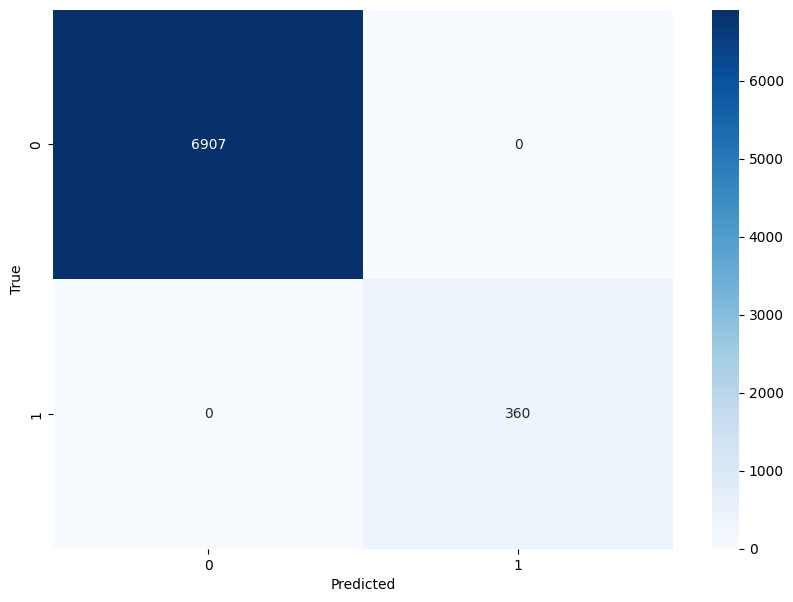

In [ ]:
# Sort the dataframe by timestamp
df = df.sort_values('timestamp').reset_index(drop=True)
# Prepare the data for HMM
X_hmm = df_with_anomalies['value'].values.reshape(-1, 1)

# Define the Gaussian HMM model
model = hmm.GaussianHMM(n_components=2, covariance_type="diag", n_iter=100)

# Fit the model
model.fit(X_hmm)

# Predict anomalies
log_probs = model.score_samples(X_hmm)[0]
threshold = np.percentile(log_probs, 1)  # Lower the percentile for the threshold
predicted_labels = model.predict(X_hmm)
predicted_labels_hmm = np.where(log_probs < threshold, 1, 0) # Changed variable name to avoid overwriting
predicted_labels_hmm = predicted_labels_hmm.tolist()

# Define confusion matrix plotting function
def plot_confusion_matrix(true_labels, predicted_labels):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Evaluate the model
evaluate_model(true_labels, predicted_labels)

# Visualize the confusion matrix
plot_confusion_matrix(true_labels, predicted_labels)


# **RNN (LSTM)**

Epoch 1/20
181/181 [==============================] - 54s 249ms/step - loss: 0.2020 - accuracy: 0.9472 - val_loss: 0.2249 - val_accuracy: 0.9439
Epoch 2/20
181/181 [==============================] - 20s 108ms/step - loss: 0.1954 - accuracy: 0.9522 - val_loss: 0.2166 - val_accuracy: 0.9439
Epoch 3/20
181/181 [==============================] - 19s 104ms/step - loss: 0.1954 - accuracy: 0.9522 - val_loss: 0.2162 - val_accuracy: 0.9439
Epoch 4/20
181/181 [==============================] - 23s 129ms/step - loss: 0.1952 - accuracy: 0.9522 - val_loss: 0.2163 - val_accuracy: 0.9439
Epoch 5/20
181/181 [==============================] - 23s 125ms/step - loss: 0.1953 - accuracy: 0.9522 - val_loss: 0.2182 - val_accuracy: 0.9439
Epoch 6/20
181/181 [==============================] - 19s 104ms/step - loss: 0.1950 - accuracy: 0.9522 - val_loss: 0.2161 - val_accuracy: 0.9439
Epoch 7/20
181/181 [==============================] - 18s 97ms/step - loss: 0.1942 - accuracy: 0.9522 - val_loss: 0.2166 - val_acc

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


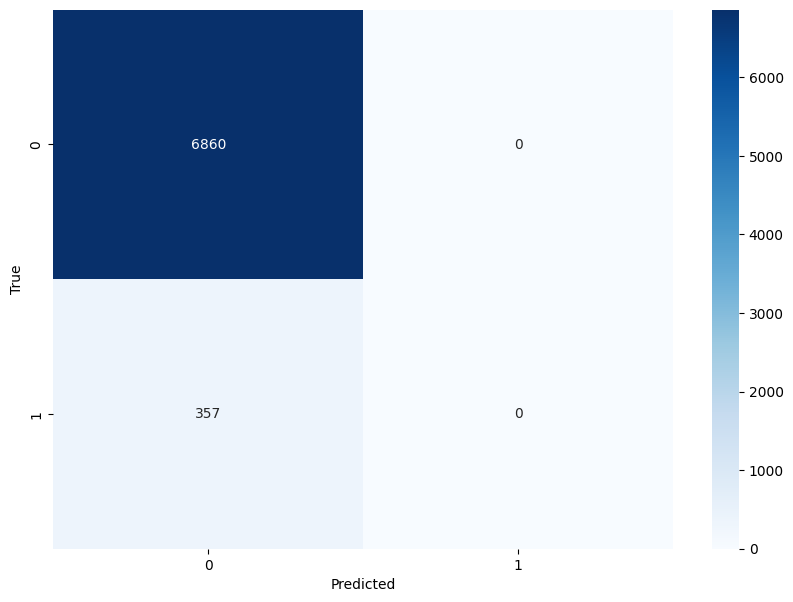

In [ ]:
sequence_length = 50
X_rnn = []
y_rnn = []
for i in range(sequence_length, len(df_with_anomalies)):
    X_rnn.append(df_with_anomalies['value'].values[i-sequence_length:i])
    y_rnn.append(true_labels[i])

X_rnn, y_rnn = np.array(X_rnn), np.array(y_rnn)

# Reshape input data to (samples, sequence_length, 1)
X_rnn = X_rnn.reshape((X_rnn.shape[0], X_rnn.shape[1], 1))

# Build the RNN model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(sequence_length, 1)),
    Dropout(0.3),
    LSTM(100),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_rnn, y_rnn, epochs=20, batch_size=32, validation_split=0.2)

# Predict anomalies
predicted_probs = model.predict(X_rnn)
predicted_labels = np.where(predicted_probs > 0.5, 1, 0).flatten()

# Evaluate the model
evaluate_model(y_rnn, predicted_labels)

# Visualize the confusion matrix
plot_confusion_matrix(y_rnn, predicted_labels)